In [1]:
# imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import pickle
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor


import os

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [3]:
# importing train.csv data and modifying entries to remove duplicate and reset index

eeg_y = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
eeg_y = eeg_y.drop_duplicates(subset='eeg_id', keep='first') # There are duplicate entries in the csv for different timestamps. For our case we can just take the first occurance.
eeg_y = eeg_y.reset_index(drop=True) # Index will be fragmented after dropping duplicate, so we reassign each entry a new index starting from 0 to n.        

# split eeg_y into train and test split
eeg_train_y, eeg_test_y = train_test_split(eeg_y, test_size=0.2, shuffle=True)

print(eeg_y.head())
print(eeg_train_y.shape)
print(eeg_test_y.shape)


       eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
0  1628180742           0                       0.0          353733   
1  2277392603           0                       0.0          924234   
2   722738444           0                       0.0          999431   
3   387987538           0                       0.0         1084844   
4  2175806584           0                       0.0         1219001   

   spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
0                   0                               0.0   127492639   
1                   0                               0.0  1978807404   
2                   0                               0.0   557980729   
3                   0                               0.0  4099147263   
4                   0                               0.0  1963161945   

   patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  lrda_vote  \
0       42516          Seizure             3         0         0   

In [4]:
# import eeg data as dictionary from dict notebook
# This is a lot faster than loading the data from kaggle into a new dictionary.
eeg_data_dict = {}
with open('/kaggle/input/notebook01c73f822d/saved_eeg_dict.pkl', 'rb') as f:
    eeg_data_dict = pickle.load(f)

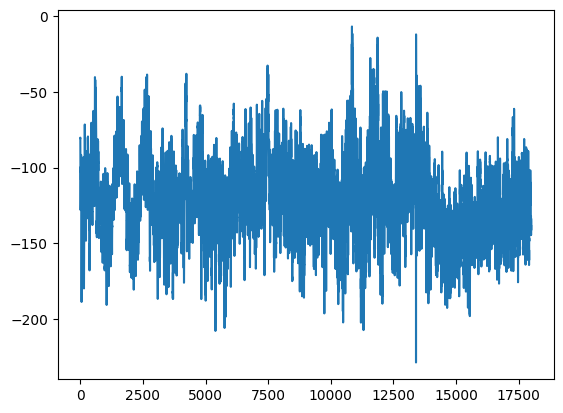

In [5]:
# plot unfiltered and un-normalized data
plt.plot(next(iter(eeg_data_dict.values()))[:, 0])
plt.show()

In [6]:
print(len(eeg_data_dict))
print(eeg_data_dict[568657])
print(len(eeg_data_dict[568657][0]))
print(len(eeg_data_dict[568657][1]))
print(len(eeg_data_dict[568657][2]))

print("hi")

17089
[[ -75.36   92.37   65.47 ...  -42.16  121.24   72.55]
 [-107.74   59.07   32.59 ...  -80.43   88.4    40.25]
 [-103.05   50.95   10.75 ...  -93.09   51.69   31.82]
 ...
 [-141.6   -47.55 -120.6  ... -145.94    2.19  -19.32]
 [-155.55  -60.48 -116.54 ... -138.28   28.15  -21.1 ]
 [-184.43 -107.31 -161.08 ... -169.9   -15.49  -55.96]]
8
8
8
hi


In [7]:
# apply frequency filter to eeg data
# Keep frequency within 1hz to 40hz
sos = signal.butter(3, [1, 40], 'bandpass', fs=200, output='sos') # this is the filter, we will apply it below with signal.sosfilt()

## Dataset and Dataloader

In [8]:
# Custom dataset
class EEGDataset(Dataset):
    def __init__(self, eeg_y, eeg_data_dict, transform=None, target_transform=None):
        self.eeg_labels = eeg_y
        self.eeg_data_dict = eeg_data_dict
#         self.transform = transform
#         self.target_transform = target_transform
    
    def __len__(self): # number of samples in our dataset
        return len(self.eeg_labels)
    
    def __getitem__(self, idx): # loads and returns a sample at index idx.
        # convert votes to probability distribution vector
        votes = eeg_y.loc[idx, ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']].to_numpy()
        total_vote = np.sum(votes)
        label = votes / total_vote
        label = torch.tensor(np.array(label, dtype=np.float64))
        
        eeg = eeg_data_dict.get(eeg_y.loc[idx, 'eeg_id'])
        
        # we need to crop the eeg to 50 seconds, starting from the offset specified in eeg_label_offset_seconds
        offset_index = int(eeg_y.loc[idx, 'eeg_label_offset_seconds']) * 200
        end_index = offset_index + 10000
        eeg = eeg[offset_index: end_index] # select 50 second of data
        
        # apply sosfilt and minmax normalization to eeg data
        sos_eeg = signal.sosfilt(sos, eeg, axis=0)
        normalized_eeg = minmax_scale(sos_eeg, axis=0)[:, 0]
        normalized_eeg = torch.tensor(normalized_eeg)
        
#         if self.transform:
#             normalized_eeg = self.transform(normalized_eeg)
#         if self.target_transform:
#             label = self.target_transform(label)
        
        return normalized_eeg, label

In [9]:
eeg_train_data_set = EEGDataset(eeg_train_y, eeg_data_dict)
eeg_test_data_set = EEGDataset(eeg_test_y, eeg_data_dict)

In [10]:
normalized_eeg, label = eeg_train_data_set[0]
print(normalized_eeg.shape, label)

torch.Size([10000]) tensor([1., 0., 0., 0., 0., 0.], dtype=torch.float64)


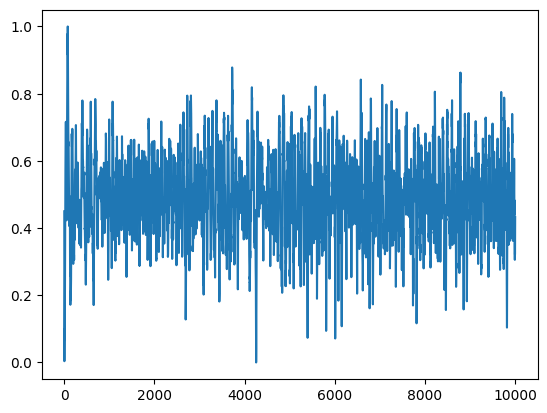

In [11]:
plt.plot(normalized_eeg)
plt.show()

In [12]:
# Dataloader
# Purpose: split the dataset up into mini batches because the hardware cannot store tens of thoasands of data in memory at one time.
train_dataloader = DataLoader(eeg_train_data_set, batch_size=32, shuffle=False)
test_dataloader = DataLoader(eeg_test_data_set, batch_size=32, shuffle=False)

In [13]:
print(train_dataloader)
print(len(train_dataloader))

428


In [14]:
train_eeg_batch, train_labels_batch = next(iter(train_dataloader))
print(f"EEG {train_eeg_batch.shape}")
print(f"Labels {train_labels_batch.shape}")


EEG torch.Size([32, 10000])
Labels torch.Size([32, 6])


# Convolution Neural Network

In [15]:
class ConvolutionNeuralNetwork1D(nn.Module):
    def __init__(self):
        super().__init__() # what does this super do?
        
        self.conv1 = nn.Conv1d(1, 64, kernel_size=5)
        # do we need a pooling layer when dealing with such little data?
        # self.conv2 = nn.Conv1d(64, 128, kernel_size=5)
        
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
        
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
    def parameters(self):
        # include function to return the parameters of the model?
        return
    

In [16]:
model = ConvolutionNeuralNetwork1D().to(device)
print("model = ", model)

learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # SGD = stochastic gradient descent
# how many parameters should we have?

model =  ConvolutionNeuralNetwork1D(
  (conv1): Conv1d(1, 64, kernel_size=(5,), stride=(1,))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential()
)
